Kaggle データセットの分析  
https://www.kaggle.com/neuromusic/avocado-prices

アメリカのハスアボカドというアボカドの品種に関する小売データセット。  
各都市の一週間ごとデータが記録されている。

- 日付 2015-01-04 ～ 2018-03-25
- アボカド1個あたり平均価格
- 消費量？
- PLU codes 生鮮食品を販売管理するためのコード。4046はアボカドサイズ（小）、4225は中、4770は大を意味する。
- TotalBags small+large+xlarge bags
- type 従来型か有機栽培か
- 都市

分析案  
- 層別（regeonごと）の平均価格の平均、総量の平均をみる
- 系列の周期性があるか確認
- 周期性あり→層別にモデルを作るのではなく、層の情報を生かしたモデルを調査
- 周期性なし→再検討

In [1]:
import pandas as pd
import numpy as np

In [2]:
# ファイル読み込み
in_file = '../data/avocado.csv'
df = pd.read_csv(in_file, header=0, index_col=0)

# 日付を文字列から日付型に変換
df['Date'] = pd.to_datetime(df['Date'])
df['type'] = pd.Series(np.where(df.type=='conventional', 1, 0), name='type')
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,1,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,1,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,1,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,1,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,1,2015,Albany


In [3]:
# テーブルサイズ確認
df.shape

(18249, 13)

In [4]:
# データの基本統計量確認
df.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.0,18249.000000
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,1.0,2016.147899
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.0,0.939938
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.0,2015.000000
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,1.0,2015.000000
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,1.0,2016.000000
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,1.0,2017.000000
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,1.0,2018.000000


In [5]:
# regionラベル54個の一覧表示
for reg in set(df.region): print(reg, end=' ')

CincinnatiDayton Albany Boise NewOrleansMobile Louisville SouthCentral Midsouth LosAngeles HarrisburgScranton BaltimoreWashington Orlando PhoenixTucson Seattle Boston NewYork Tampa Pittsburgh Plains Indianapolis TotalUS GrandRapids Atlanta SanDiego Denver Jacksonville Nashville Philadelphia Northeast BuffaloRochester Columbus Sacramento California DallasFtWorth WestTexNewMexico RichmondNorfolk SouthCarolina Syracuse NorthernNewEngland MiamiFtLauderdale LasVegas Detroit Portland SanFrancisco West Chicago HartfordSpringfield Southeast RaleighGreensboro GreatLakes Roanoke Spokane StLouis Houston Charlotte 

In [6]:
# regionごとに平均値出力
df_groupby = df.groupby("region",as_index=False)
df_groupby.mean().head()

,region,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year
0,Albany,1.561036,47537.869734,1824.081775,37621.208254,162.832337,7929.747367,6647.765473,1153.496213,128.488639,1,2016.147929
1,Atlanta,1.337959,262145.322041,146116.867959,31218.510385,311.385769,84498.560888,51605.727337,32070.044556,822.786036,1,2016.147929
2,BaltimoreWashington,1.534231,398561.891479,35656.218166,245982.888876,12466.730976,104456.053462,100939.683195,2903.984586,612.382722,1,2016.147929
3,Boise,1.348136,42642.567308,20019.507604,3461.682367,3186.787840,15974.592456,13840.037249,2103.634083,30.915207,1,2016.147929
4,Boston,1.530888,287792.854527,4994.610059,214219.864290,4982.294970,63596.085207,58906.590355,4438.364704,251.124231,1,2016.147929


In [7]:
# regionごと平均の基本統計量
df_groupby.mean().describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year
count,54.000000,5.400000e+01,5.400000e+01,5.400000e+01,54.000000,5.400000e+01,5.400000e+01,5.400000e+01,54.000000,54.0,54.000000
mean,1.405955,8.505751e+05,2.930015e+05,2.951169e+05,22837.438880,2.396171e+05,1.821745e+05,5.433654e+04,3106.069740,1.0,2016.147898
std,0.166653,2.419120e+06,8.683353e+05,8.363299e+05,66626.358138,6.768062e+05,5.138323e+05,1.607019e+05,9179.465604,0.0,0.000226
min,1.047929,3.237476e+04,9.816233e+02,3.461682e+03,78.368846,7.929747e+03,6.647765e+03,2.269676e+02,21.250651,1.0,2016.146269
25%,1.287848,1.052357e+05,2.052716e+04,3.167778e+04,834.040740,3.481852e+04,2.645064e+04,3.273603e+03,258.645022,1.0,2016.147929
50%,1.400725,2.120883e+05,5.705663e+04,6.370831e+04,4783.209911,5.569507e+04,4.129541e+04,1.216920e+04,639.571169,1.0,2016.147929
75%,1.515947,5.419719e+05,1.677572e+05,2.380421e+05,11830.519808,1.480396e+05,1.158157e+05,3.462434e+04,1239.461501,1.0,2016.147929
max,1.818639,1.735130e+07,6.079693e+06,5.961573e+06,462056.754822,4.847931e+06,3.679175e+06,1.105279e+06,63477.013432,1.0,2016.147929


In [8]:
# seabornで可視化
# これで都市ごと年毎に平均価格が異なるということがわかる
# カーネル通りに実行
# https://www.kaggle.com/neuromusic/avocado-prices-across-regions-and-seasons
import seaborn as sns
sns.set_style('white')

mask = df['type']==1
g = sns.factorplot('AveragePrice','region',data=df[mask],
                   hue='year',
                   size=8,
                   aspect=0.6,
                   palette='Blues',
                   join=False,
              )

In [9]:
order = (
    df[mask & (df['year']==2018)]
    .groupby('region')['AveragePrice']
    .mean()
    .sort_values()
    .index
)

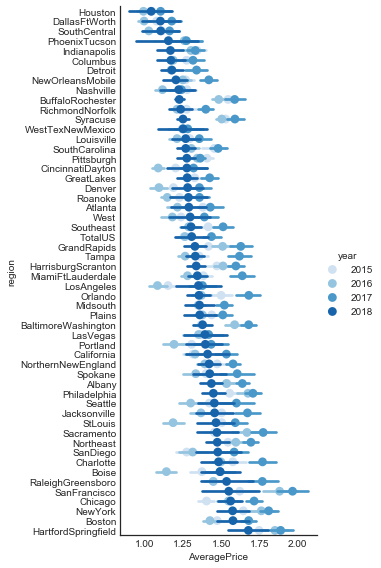

In [10]:
# ソートして最後プロット
# アメリカ南部ほど安く、北部ほど高い傾向
# これもカーネル通り実行
# https://www.kaggle.com/neuromusic/avocado-prices-across-regions-and-seasons
g = sns.factorplot('AveragePrice','region',data=df[mask],
                   hue='year',
                   size=8,
                   aspect=0.6,
                   palette='Blues',
                   order=order,
                   join=False,
              )

In [11]:
# 都市をダミー変数に変換して結合
cities = pd.get_dummies(df.region, prefix='City')
df_dummy = pd.concat([df, cities], axis=1)

In [12]:
# 予測用データセット作成
y = {'average price': df_dummy['AveragePrice']}
del df_dummy['AveragePrice']
del df_dummy['Date']
del df_dummy['region']
del df_dummy['4046']
del df_dummy['4225']
del df_dummy['4770']

In [13]:
# 学習データとテストデータ作成
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_dummy, pd.DataFrame(y))

In [14]:
# モデル作成
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
lars = linear_model.Lars()
lars_cv = linear_model.LarsCV()
lasso = linear_model.Lasso()
lasso_cv = linear_model.LassoCV()
lasso_lars = linear_model.LassoLars()
lasso_lars_cv = linear_model.LassoLarsCV()
lasso_lars_aic = linear_model.LassoLarsIC(criterion='aic')
lasso_lars_bic = linear_model.LassoLarsIC(criterion='bic')
linear_reg = linear_model.LinearRegression()
knn_1 = KNeighborsRegressor(n_neighbors=1)
knn_3 = KNeighborsRegressor(n_neighbors=3)
knn_5 = KNeighborsRegressor(n_neighbors=5)
knn_7 = KNeighborsRegressor(n_neighbors=7)
knn_9 = KNeighborsRegressor(n_neighbors=9)
knn_11 = KNeighborsRegressor(n_neighbors=11)

In [15]:
def run(model, lab):
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    ac_mse = mean_squared_error(y_test, y_pred)
    ac_r2 = r2_score(y_test, y_pred)
    print('{:12}\tMSE: {:.4f}\tR2: {:.4f}'.format(lab, ac_mse, ac_r2))

In [16]:
# 精度確認
run(lars, 'lars')
run(lars_cv, 'lars_cv')
run(lasso, 'lasso')
run(lasso_cv, 'lasso_cv')
run(lasso_lars, 'lasso_lars')
run(lasso_lars_cv, 'lasso_lars_cv')
run(lasso_lars_aic, 'lasso_lars_aic')
run(lasso_lars_bic, 'lasso_lars_bic')
run(linear_reg, 'linear_reg')
run(knn_1, 'knn_1')
run(knn_3, 'knn_3')
run(knn_5, 'knn_5')
run(knn_7, 'knn_7')
run(knn_9, 'knn_9')
run(knn_11, 'knn_11')

lars        	MSE: 0.1234	R2: 0.2209
lars_cv     	MSE: 0.1234	R2: 0.2205
lasso       	MSE: 0.1524	R2: 0.0378
lasso_cv    	MSE: 0.1524	R2: 0.0376
lasso_lars  	MSE: 0.1585	R2: -0.0013
lasso_lars_cv	MSE: 0.1234	R2: 0.2205
lasso_lars_aic	MSE: 0.1234	R2: 0.2209
lasso_lars_bic	MSE: 0.1240	R2: 0.2167
linear_reg  	MSE: 0.1233	R2: 0.2212
knn_1       	MSE: 0.1262	R2: 0.2028
knn_3       	MSE: 0.0828	R2: 0.4773
knn_5       	MSE: 0.0751	R2: 0.5257
knn_7       	MSE: 0.0723	R2: 0.5434
knn_9       	MSE: 0.0721	R2: 0.5445
knn_11      	MSE: 0.0711	R2: 0.5510
